This is a Machine Learning: Linear Regression Project
The Aim of the project is to create a model to predict household prices.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from function_file import clean_names

Import Dataframe house_price.csv, then apply clean_names to clean column names

In [2]:
raw_df = pd.read_csv(r"data_in\house_price.csv").rename(columns = clean_names)

# Make a copy from the raw data
df = raw_df.copy()
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')

No Missing values (NaN) within raw dataframe

There is only 1 unique entry for country, and 2 unique value for water front.

Actions
- Convert "waterfront" into boolean type.
- Drop "country" due to 1 unique value has no impact on our predictive analysis. 
- Drop "date" as it only contains 2 months worth of data.
- In addition, for simplicity, we are going to drop "street","statezip" columns.
- (That being said, timeframe and location does influence the house pricing.) 
- Apply log transform to price columns

In [3]:
# Check NA, No NAs for this dataframe
print("NA Counts: ", df.isnull().sum())
#Check unique Observations for each columns
print(df.nunique().reset_index().sort_values(by=0))

# Drop Country & Date
df.drop(columns = ["country", "date", "street","statezip"], inplace = True);
# Convert Water front into boolean type as it only contains 2 unique obervations
df["waterfront"] = df["waterfront"].astype('bool')

NA Counts:  date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64
            index     0
17        country     1
7      waterfront     2
9       condition     5
8            view     5
6          floors     6
2        bedrooms    10
3       bathrooms    26
15           city    44
13   yr_renovated    60
0            date    70
16       statezip    77
12       yr_built   115
11  sqft_basement   207
10     sqft_above   511
4     sqft_living   566
1           price  1741
5        sqft_lot  3113
14         street  4525


Predictor EDA

In the histogram below, we observed that there are House Pricing equal to 0. Further inspect found that there are 49 entries that has a pricing == $0.00. 
In real world, we could need to find / ask to refine the zero entries.

For this excercise, we can utilise those price = $0.00 as our predicting subjects.

In [4]:
# We will be using the price $0.00 house as our predicted subjects
df_use_for_prediction = df.loc[df["price"]== 0]

# Excluding £0.00 from the main dataframe.
df = df.loc[df["price"]!=0]

count    4.551000e+03
mean     5.579059e+05
std      5.639299e+05
min      7.800000e+03
25%      3.262643e+05
50%      4.650000e+05
75%      6.575000e+05
max      2.659000e+07
Name: price, dtype: float64
Count of records that has $0.00:  0


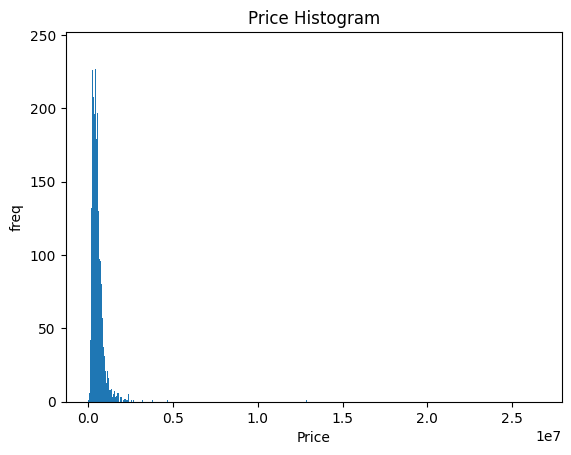

In [5]:
plt.hist(df["price"], bins = 1000)
plt.xlabel('Price')
plt.ylabel('freq')
plt.title('Price Histogram')

print(df["price"].describe())
print("Count of records that has $0.00: ", df['price'].loc[df["price"]==0].count())

Text(0.5, 1.0, 'Price Histogram')

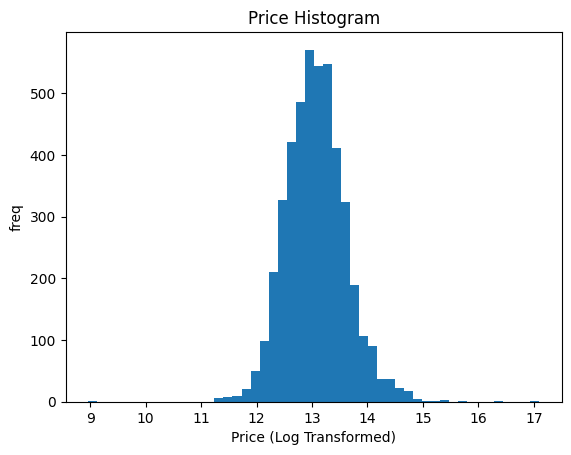

In [6]:
log_price = np.log(df["price"])

df.insert(0, 'log_price', log_price) 

plt.hist(df["log_price"], bins = 50)
plt.xlabel('Price (Log Transformed)')
plt.ylabel('freq')
plt.title('Price Histogram')

Text(0.5, 1.0, 'Predictor Price Boxplot')

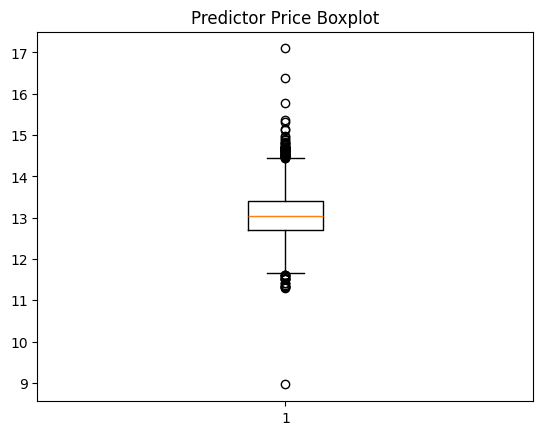

In [7]:
plt.boxplot(df["log_price"])
plt.title('Predictor Price Boxplot')

Numerical Feature Selections


2. Assumption that R2 >=|0.6|, indicate colinearity between features.
3. Assumption that R2 >=|0.1|, indicate that there is no direct correlation between predictor & features

Numerical Features Summary (Sorted by R2):

Features         R2
sqft_living      0.671 ✔ 
sqft_above       0.582 X (Collinearity with sqft_living)
bathrooms        0.549 X (Collinearity with sqft_living)
bedrooms         0.355 ✔
view             0.324 ✔
sqft_basement    0.313 ✔
floors           0.305 ✔
sqft_lot         0.086 X (R2 shows no correlation)
condition        0.059 X (R2 shows no correlation)
yr_built         0.059 X (R2 shows no correlation)
yr_renovated    -0.063 X (R2 shows no correlation)

In [8]:
df_numeric_feat = df.copy()
df_numeric_feat = df_numeric_feat.drop(["price"],axis = 1)
df_numeric_feat = df_numeric_feat.select_dtypes(['int64','float64'])

# Create Correlation Matrix for the numerical variable
corr = df_numeric_feat.corr().round(3)
corr_sort = corr.sort_values(by = ["log_price"], ascending = False)
print(corr_sort["log_price"])
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

log_price        1.000
sqft_living      0.671
sqft_above       0.582
bathrooms        0.549
bedrooms         0.355
view             0.324
sqft_basement    0.313
floors           0.305
sqft_lot         0.086
condition        0.059
yr_built         0.059
yr_renovated    -0.063
Name: log_price, dtype: float64


,log_price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
log_price,1.000,0.355,0.549,0.671,0.086,0.305,0.324,0.059,0.582,0.313,0.059,-0.063
bedrooms,0.355,1.000,0.548,0.596,0.071,0.176,0.115,0.023,0.486,0.335,0.141,-0.062
bathrooms,0.549,0.548,1.000,0.757,0.109,0.490,0.206,-0.121,0.687,0.296,0.464,-0.218
sqft_living,0.671,0.596,0.757,1.000,0.213,0.344,0.309,-0.063,0.876,0.450,0.285,-0.122
sqft_lot,0.086,0.071,0.109,0.213,1.000,0.004,0.073,0.001,0.219,0.036,0.049,-0.021
floors,0.305,0.176,0.490,0.344,0.004,1.000,0.032,-0.274,0.522,-0.255,0.467,-0.236
view,0.324,0.115,0.206,0.309,0.073,0.032,1.000,0.063,0.175,0.317,-0.066,0.026
condition,0.059,0.023,-0.121,-0.063,0.001,-0.274,0.063,1.000,-0.177,0.197,-0.399,-0.184
sqft_above,0.582,0.486,0.687,0.876,0.219,0.522,0.175,-0.177,1.000,-0.038,0.406,-0.161
sqft_basement,0.313,0.335,0.296,0.450,0.036,-0.255,0.317,0.197,-0.038,1.000,-0.163,0.047


Feature Selection: Water Fron & Cities

Categorical Features

Features              R2
waterfront            0.142
city_Bellevue         0.225
city_Mercer Island    0.202
city_Sammamish        0.127
city_Redmond          0.126
city_Medina           0.117
city_Maple Valley    -0.100
city_Tukwila         -0.105
city_Covington       -0.108
city_Des Moines      -0.111
city_Renton          -0.139
city_Federal Way     -0.175
city_Kent            -0.179
city_Auburn          -0.192

1. Waterfront shows correlation with the house pricing.
2. For the list of cities that has correlation with log_price This could be a confound feature since it is related to the area/zip code rather than city itself. 

In [9]:
df_feat_waterfront = df[["log_price","waterfront"]].copy()
feat_corr = df_feat_waterfront.corr().round(3)

print(feat_corr["log_price"])
feat_corr.style.format(precision=3).background_gradient(cmap='coolwarm')

log_price     1.000
waterfront    0.142
Name: log_price, dtype: float64


,log_price,waterfront
log_price,1.000,0.142
waterfront,0.142,1.000


In [10]:
df_feat_city = df[['log_price', 'city']].copy()

# Apply One-Hot Encoding to the city
df_feat_city = pd.get_dummies(df_feat_city, prefix = ["city"], columns = ["city"])

corr = df_feat_city.corr().round(3)
# Since it is high density observations, hence we are doing prefilter |R2| >= 0.1
corr = corr[corr["log_price"].abs()>=0.1]
# Sort by Correlation
corr_sort = corr.sort_values(by = ["log_price"], ascending = False)

corr_sort["log_price"]

log_price             1.000
city_Bellevue         0.225
city_Mercer Island    0.202
city_Sammamish        0.127
city_Redmond          0.126
city_Medina           0.117
city_Maple Valley    -0.100
city_Tukwila         -0.105
city_Covington       -0.108
city_Des Moines      -0.111
city_Renton          -0.139
city_Federal Way     -0.175
city_Kent            -0.179
city_Auburn          -0.192
Name: log_price, dtype: float64

Gather All Numerical and Categorical Features


Features Summary:

Features               R2
sqft_living           0.671
bedrooms              0.355
view                  0.324
sqft_basement         0.313
floors                0.305
waterfront            0.142
city_Bellevue         0.225
city_Mercer Island    0.202
city_Sammamish        0.127
city_Redmond          0.126
city_Medina           0.117
city_Maple Valley    -0.100
city_Tukwila         -0.105
city_Covington       -0.108
city_Des Moines      -0.111
city_Renton          -0.139
city_Federal Way     -0.175
city_Kent            -0.179
city_Auburn          -0.192

In [11]:
screen_features = ['log_price','sqft_living','view','sqft_basement','bedrooms','floors', 'waterfront', 'city']
corr_city = ['Bellevue', 'Mercer Island', 'Sammamish', 'Redmond', 'Medina', 'Maple Valley', 'Tukwila', 'Covington', 'Des Moines', 'Renton', 'Federal Way', 'Kent', 'Auburn']

#Gather all screened feature
df_feat = df[screen_features].copy()

# Create a boolean for the correlated_ctiies
df_feat['correlate_city'] = np.where(df_feat['city'].isin(corr_city), df_feat['city'], np.nan)

df_feat = pd.get_dummies(df_feat, prefix = ["city_"], columns = ["correlate_city"])

# Drop City Column
df_feat.drop(columns = ["city"], inplace = True)


# Create Correlation Matrix for the numerical variable
corr = df_feat.corr().round(3)
corr_sort = corr.sort_values(by = ["log_price"], ascending = False)
print(corr_sort["log_price"])
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

log_price              1.000
sqft_living            0.671
bedrooms               0.355
view                   0.324
sqft_basement          0.313
floors                 0.305
city__Bellevue         0.225
city__Mercer Island    0.202
waterfront             0.142
city__Sammamish        0.127
city__Redmond          0.126
city__Medina           0.117
city__Maple Valley    -0.100
city__Tukwila         -0.105
city__Covington       -0.108
city__Des Moines      -0.111
city__Renton          -0.139
city__Federal Way     -0.175
city__Kent            -0.179
city__Auburn          -0.192
Name: log_price, dtype: float64


,log_price,sqft_living,view,sqft_basement,bedrooms,floors,waterfront,city__Auburn,city__Bellevue,city__Covington,city__Des Moines,city__Federal Way,city__Kent,city__Maple Valley,city__Medina,city__Mercer Island,city__Redmond,city__Renton,city__Sammamish,city__Tukwila
log_price,1.000,0.671,0.324,0.313,0.355,0.305,0.142,-0.192,0.225,-0.108,-0.111,-0.175,-0.179,-0.100,0.117,0.202,0.126,-0.139,0.127,-0.105
sqft_living,0.671,1.000,0.309,0.450,0.596,0.344,0.108,-0.024,0.145,-0.037,-0.038,-0.012,-0.033,-0.007,0.102,0.159,0.088,-0.007,0.138,-0.036
view,0.324,0.309,1.000,0.317,0.115,0.032,0.348,-0.028,0.055,-0.030,0.068,-0.013,-0.054,-0.037,0.014,0.103,-0.055,-0.038,-0.015,-0.017
sqft_basement,0.313,0.450,0.317,1.000,0.335,-0.255,0.089,-0.068,0.117,-0.034,-0.002,-0.010,-0.046,-0.086,0.040,0.098,-0.054,-0.048,-0.065,-0.004
bedrooms,0.355,0.596,0.115,0.335,1.000,0.176,-0.006,0.005,0.115,-0.012,-0.019,0.023,0.014,0.013,0.038,0.109,0.007,0.023,0.070,-0.029
floors,0.305,0.344,0.032,-0.255,0.176,1.000,0.016,-0.023,-0.056,-0.032,-0.055,-0.056,-0.021,0.077,0.011,0.020,0.022,-0.018,0.094,-0.020
waterfront,0.142,0.108,0.348,0.089,-0.006,0.016,1.000,-0.016,0.002,-0.008,0.039,0.001,-0.017,-0.012,-0.004,0.071,0.006,-0.021,0.012,-0.007
city__Auburn,-0.192,-0.024,-0.028,-0.068,0.005,-0.023,-0.016,1.000,-0.051,-0.019,-0.023,-0.036,-0.041,-0.029,-0.010,-0.027,-0.047,-0.052,-0.040,-0.016
city__Bellevue,0.225,0.145,0.055,0.117,0.115,-0.056,0.002,-0.051,1.000,-0.025,-0.029,-0.047,-0.053,-0.037,-0.013,-0.035,-0.060,-0.067,-0.051,-0.021
city__Covington,-0.108,-0.037,-0.030,-0.034,-0.012,-0.032,-0.008,-0.019,-0.025,1.000,-0.011,-0.018,-0.020,-0.014,-0.005,-0.013,-0.023,-0.025,-0.019,-0.008


In [12]:
df_feat_corr = df[screen_features].copy()
df_feat_corr['correlate_city'] = np.where(df_feat_corr['city'].isin(corr_city), df_feat_corr['city'], "Other")

# Commented out due to long run time
# sns.pairplot(df_feat_corr, hue="correlate_city")

Baseline Model

1. Applying Standard Scaler as there outliner influencing 
1. Create a Baseline Model where used pricing ~ sqft_living (highest correlation |R2|)
- model_baseline, R2 = 0.449

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['sqft_living', 'bedrooms', 'view', 'sqft_basement', 'floors']

#Linear Regression Model
lm = LinearRegression()

# Standard Scaler (Standard Normal)
scaler = StandardScaler()

X_scaled = df_feat_corr.copy()

#Remove Predictor Columns
X_scaled = X_scaled.drop("log_price", axis = 1)
# Scale Numeric Columns
X_scaled[columns_to_scale] = scaler.fit_transform(X_scaled[columns_to_scale])

In [14]:
X = X_scaled[['sqft_living']]
y = df_feat_corr["log_price"]

# Split Model into Train, Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lm.fit(X_train, y_train)

pred = lm.predict(X_test)
lm.score(X_test, y_test)

print("Baseline_Model Model Score: ", r2_score(y_test,pred).round(3))

Baseline_Model Model Score:  0.449


In [15]:
X = X_scaled[['sqft_living', 'bedrooms', 'view']]

y = df_feat_corr["log_price"]

# Split Model into Train, Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lm.fit(X_train, y_train)

pred = lm.predict(X_test)
lm.score(X_test, y_test)

print("Model 2 Model Score: ", r2_score(y_test,pred).round(3))

Model 2 Model Score:  0.462


In [16]:
X = X_scaled.copy()
X = pd.get_dummies(X, prefix = ["city"], columns = ["correlate_city"])
X = X.drop("city", axis = 1)

y = df_feat_corr["log_price"]

# Split Model into Train, Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lm.fit(X_train, y_train)

pred = lm.predict(X_test)
lm.score(X_test, y_test)

print("Model 2 Model Score: ", r2_score(y_test,pred).round(3))

Model 2 Model Score:  0.645


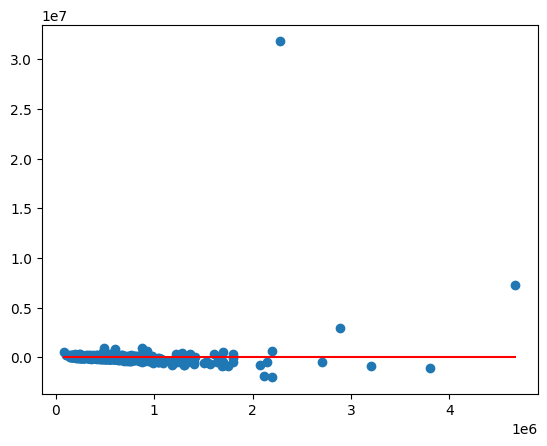

In [17]:
output = pd.DataFrame({"actual_price":np.exp(y_test), 'predicted_price':np.exp(pred)})
output["error"] = output["predicted_price"] - output["actual_price"]

plt.scatter(output["actual_price"], output["error"])

plt.plot([min(output["actual_price"]), max(output["actual_price"])],[0,0 ], color = "red")

# plt.scatter(pred,y_test)
# plt.plot([0, max(output["actual_price"])],[0, max(output["actual_price"])], color = "red")
# plt.title('Prediction vs Actual Test data, (Red line is 1)')
# plt.xlabel("prediction (Dependent Variable)")
# plt.ylabel("actual")

In [18]:
max(output["actual_price"])

4667999.999999999

In [38]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [19]:
cdf = pd.DataFrame(lm.coef_, X.columns, columns = ["Coef"])
cdf

,Coef
sqft_living,189.964681
sqft_above,76.952144
bathrooms,-22173.509350
view,51998.199695
sqft_basement,113.012537
bedrooms,-57781.794368
floors,54335.672695
waterfront,427381.930884
sqft_lot,-0.405265
correlate_city,252218.503215


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# scale_df = scaler.fit_transform(clean_df)



# clean_df = pd.get_dummies(clean_df, prefix = ["city_"], columns = ["city"])

In [19]:
clean_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'city'],
      dtype='object')

Let's Sort the correlation against price (Dependent Variable)

Features Selection:
1. sqft_living


In [16]:
corr_sort = corr.sort_values(by = ["price"], ascending = False)
corr_sort.style.background_gradient(cmap='coolwarm')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city__Algona,city__Auburn,city__Beaux Arts Village,city__Bellevue,city__Black Diamond,city__Bothell,city__Burien,city__Carnation,city__Clyde Hill,city__Covington,city__Des Moines,city__Duvall,city__Enumclaw,city__Fall City,city__Federal Way,city__Inglewood-Finn Hill,city__Issaquah,city__Kenmore,city__Kent,city__Kirkland,city__Lake Forest Park,city__Maple Valley,city__Medina,city__Mercer Island,city__Milton,city__Newcastle,city__Normandy Park,city__North Bend,city__Pacific,city__Preston,city__Ravensdale,city__Redmond,city__Renton,city__Sammamish,city__SeaTac,city__Seattle,city__Shoreline,city__Skykomish,city__Snoqualmie,city__Snoqualmie Pass,city__Tukwila,city__Vashon,city__Woodinville,city__Yarrow Point
price,1.000000,0.200336,0.327110,0.430410,0.050451,0.151461,0.135648,0.228504,0.034915,0.367570,0.210427,0.021857,-0.028774,-0.020167,-0.089375,0.005049,0.134828,-0.016677,-0.010633,-0.046045,-0.005313,0.066867,-0.044063,-0.049503,-0.025194,-0.033918,0.012220,-0.084757,-0.003321,0.016139,-0.022357,-0.040837,0.036375,-0.016303,-0.055803,0.129795,0.140007,-0.009876,0.017201,-0.005022,-0.028337,-0.020944,0.000388,-0.002624,0.047612,-0.080926,0.047604,-0.043327,0.035642,-0.038682,-0.014453,-0.003477,-0.000705,-0.034427,-0.011219,0.016361,0.033640
sqft_living,0.430410,0.594884,0.761154,1.000000,0.210538,0.344850,0.117616,0.311009,-0.062826,0.876443,0.447206,0.287775,-0.122817,-0.018178,-0.024804,-0.009942,0.148424,-0.012689,0.015891,-0.043017,0.018218,0.075316,-0.034977,-0.038336,0.002213,-0.017620,0.036935,-0.016136,-0.009483,0.068289,-0.003610,-0.033598,0.025677,0.013252,-0.008080,0.099855,0.162803,-0.019151,0.048521,-0.002998,-0.015668,-0.023209,0.003046,0.019194,0.084903,-0.006658,0.142635,-0.038112,-0.232573,-0.062733,-0.020760,0.074974,-0.000602,-0.035822,-0.020647,0.087066,0.010205
sqft_above,0.367570,0.484705,0.689918,0.876443,0.216455,0.522814,0.078911,0.174327,-0.178196,1.000000,-0.038723,0.408535,-0.160426,-0.008367,0.008094,-0.011756,0.106131,-0.001001,0.012879,-0.053222,0.030390,0.039497,-0.020105,-0.041651,0.020440,-0.000303,0.044557,-0.011031,-0.005256,0.070544,-0.004929,-0.013566,0.030537,-0.002952,0.037597,0.090456,0.127431,-0.013845,0.076165,-0.007964,0.006315,-0.012846,0.009138,0.035576,0.124184,0.019192,0.193036,-0.036218,-0.325732,-0.064932,-0.013945,0.113295,-0.005427,-0.037820,-0.007024,0.107353,0.022081
bathrooms,0.327110,0.545920,1.000000,0.761154,0.107837,0.486428,0.076232,0.211960,-0.119994,0.689918,0.298020,0.463498,-0.215886,-0.010978,-0.017430,-0.007730,0.096217,-0.023210,0.029395,-0.067579,0.000853,0.028289,-0.023536,-0.043077,0.013111,-0.040131,0.025449,-0.012262,-0.003026,0.113674,0.005566,-0.005649,0.043793,0.012468,0.034564,0.055266,0.118618,-0.010933,0.038433,-0.011751,0.005241,-0.009337,0.005700,-0.006232,0.065146,-0.012914,0.106008,-0.044382,-0.182717,-0.076141,-0.016108,0.075567,0.011086,-0.050515,-0.031239,0.044429,-0.008406
view,0.228504,0.111028,0.211960,0.311009,0.073907,0.031211,0.360935,1.000000,0.063077,0.174327,0.321602,-0.064465,0.022967,-0.010199,-0.029638,-0.004559,0.049939,-0.013690,-0.026283,0.049267,0.006905,0.036329,-0.030035,0.065190,-0.029680,0.036849,0.002018,-0.015221,-0.004559,-0.039604,-0.020864,-0.054763,-0.019804,0.010576,-0.037325,0.013455,0.107856,-0.006449,-0.026283,0.043254,-0.002782,-0.011174,-0.006449,-0.012071,-0.055251,-0.034896,-0.011847,-0.006983,0.052671,-0.002771,-0.007899,0.006602,-0.004559,-0.017570,0.102412,-0.044144,0.009830
sqft_basement,0.210427,0.334165,0.298020,0.447206,0.034842,-0.255510,0.097501,0.321602,0.200632,-0.038723,1.000000,-0.161675,0.043125,-0.022183,-0.066510,0.001205,0.110874,-0.024474,0.009055,0.009591,-0.018643,0.082931,-0.035240,-0.002186,-0.033377,-0.036004,-0.006118,-0.012994,-0.009916,0.010676,0.001665,-0.044526,-0.003438,0.032986,-0.086608,0.039198,0.101147,-0.014025,-0.040789,0.008572,-0.044246,-0.024302,-